# **Richter's Predictor: Modeling Earthquake Damage - Feature Engineering**

## Outline

In this notebook, we will first engineer the target variable that we will use in our model. Further, we will create features that can help improve our model in predicting the degree of damage. Here is a quick overview how this notebook is structured:
- Import Libraries & Setup
- Engineering the Target Variable
    - Version 1
    - Version 2
    - Version 3
- Feature Engineering
    - Superstructures
    - Age
    - Plinth
    - Height
- Final Preparation of Data & Overview
    - Clean up
    - Overview Engineered features
    

## Import Libraries & Setup
Let us start with importing the libraries and loading the data.

In [1]:
# Importing all necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import random
import pickle

from imblearn.over_sampling import SMOTE 
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.combine import SMOTETomek

from pandas_profiling import ProfileReport

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.metrics import plot_confusion_matrix, recall_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, KBinsDiscretizer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
from sklearn.feature_selection import RFECV

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

import statsmodels.formula.api as smf

import matplotlib            
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
matplotlib.use('Qt5Agg')
%matplotlib inline

RSeed = 42
print(matplotlib.rcParams['backend'])

module://matplotlib_inline.backend_inline


### Loading the Data

In [2]:
# Loading the data
df = pd.read_pickle("data/clean/data_clean_without_outliers.csv")

## Engineering the Target Variable

As we saw in the previous notebook, there are 5 different damage classes, which are probably too much. With reagrds to our objective we do not need such a fine grained prediction of the damage grade. Therefore, we will reduce the variable to 3 damage classes. Hence, the result will be a variable with a low, moderate, and high damage grade.

Of course, there is more than one way to reshape from 5 to 3 classes. To see which class combinations make the most sense, we will create three substantially meaningful class combinations and examine their correlation with the most correlated features. Moreover, we will have a look at how the proposed classes are distributed. Overall, three different versions of damage_grade are investigated. As a reminder, we will first present the original version of damage_grade.

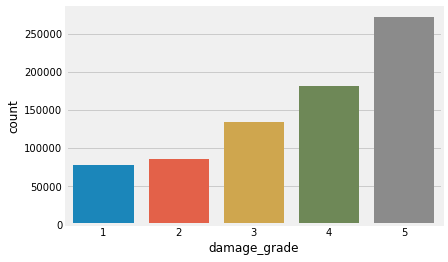

In [3]:
# Overview of the original damage_grade variable using a countplot
sns.countplot(x='damage_grade', data=df);

The plot above shows the distribution of the target variable. Overall, most buildings have major damage. The  classes are quite imbalanced.

In [4]:
# Copy df to engineer damage_grade
df_damage_grade1 = df.copy()
df_damage_grade2 = df.copy()
df_damage_grade3 = df.copy()

Later on, we will need a list with the features that correlate the best with our target variable. We will create this list in the next step.

In [5]:
df_damage_grade_selct = ["damage_grade",
                          "age_building", 
                          "plinth_area_sq_ft",
                          "height_ft_pre_eq",
                          "has_superstructure_mud_mortar_stone",
                          "count_floors_pre_eq",
                          "has_superstructure_mud_mortar_brick", 
                          "has_superstructure_rc_non_engineered",
                          "has_superstructure_rc_engineered"]

#### Version 1

In the first version of our target, the first and second grades are combined into one grade (first grade), the third and fourth grades are combined into one grade (second grade), and the fifth grade remains unchanged. 

In [6]:
# Dictionary with version 1 of damage_grade
damage_grade_version1 = {"damage_grade": { 1 : 1, 2 : 1, 3: 2, 4 : 2, 5: 3}}

In [7]:
# Replace original version of damage_grade with version 1
df_damage_grade1 = df_damage_grade1.replace(damage_grade_version1)


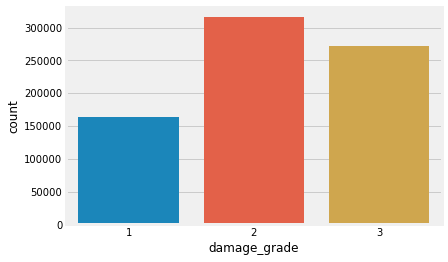

In [8]:
# Plot version 1 of damage_grade
sns.countplot(x='damage_grade', data=df_damage_grade1);

The classes look more balanced compared to the previous version. Lets have a look at the correlation between damage_grade and most correlated features.

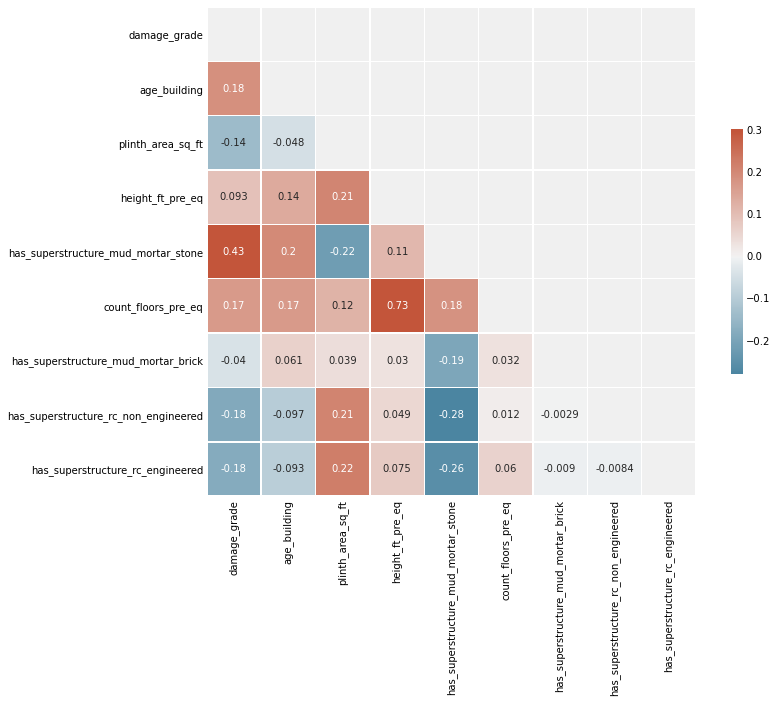

In [9]:
# Compute the correlation matrix of the target variable and most correlated features

corr = df_damage_grade1[df_damage_grade_selct].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot = True);

#### Version 2

Now we will create another version of our target variable using the same procedure as above. This time, the first grade remains unchanged, the second, third and fourth grade are combined into one grade (second grade) and the fifth grade remains unchanged. 

In [10]:
# Dictionary with version 2 of damage_grade
damage_grade_version2 = {"damage_grade": { 1 : 1, 2 : 2, 3: 2, 4 : 2, 5: 3}}

In [11]:
# Replace original version of damage_grade with version 1
df_damage_grade2 = df_damage_grade2.replace(damage_grade_version2)

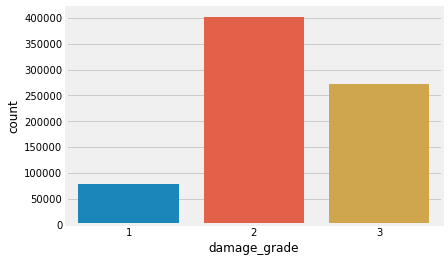

In [12]:
# Plot version 3 of damage_grade
sns.countplot(x='damage_grade', data=df_damage_grade2);

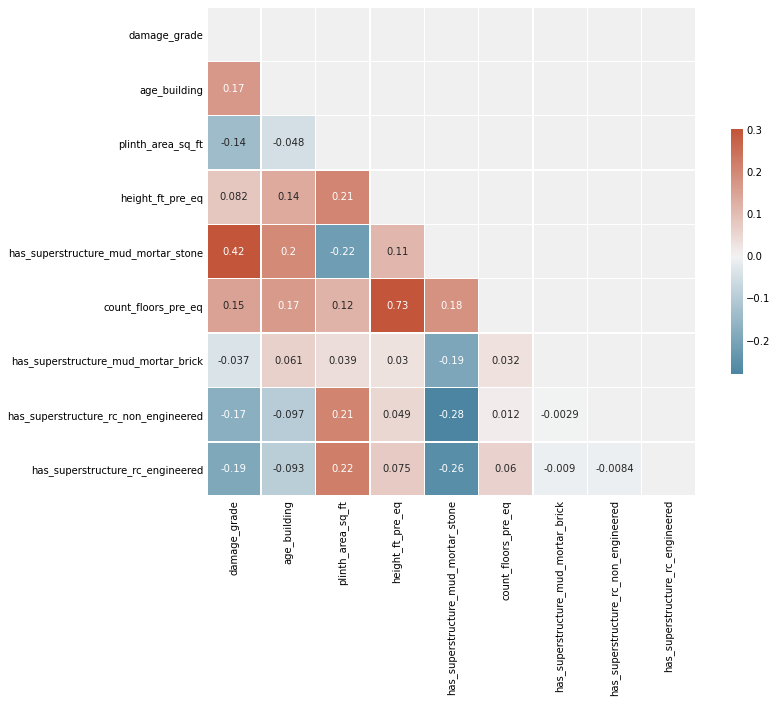

In [13]:
# Compute the correlation matrix of the target variable and most correlated features

corr = df_damage_grade2[df_damage_grade_selct].corr()

#corr = df_damage_grade2.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot = True);

#### Version 3

Now we will continue with the last version of our target variable. In this version of our target, the first and second grades are combined into one grade (first grade), the third grade remains unchanged (second grade) and the fourth grades and fith grade are combined into one grade (third grade).

In [14]:
# Dictionary with version 3 of damage_grade
damage_grade_version3 = {"damage_grade": { 1 : 1, 2 : 1, 3: 2, 4 : 3, 5: 3}}

In [15]:
# Replace original version of damage_grade with version 3
df_damage_grade3 = df_damage_grade3.replace(damage_grade_version3)

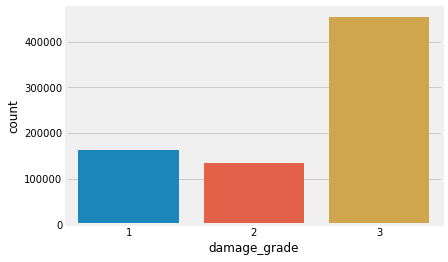

In [16]:
# Plot version 3 of damage_grade
sns.countplot(x='damage_grade', data=df_damage_grade3);

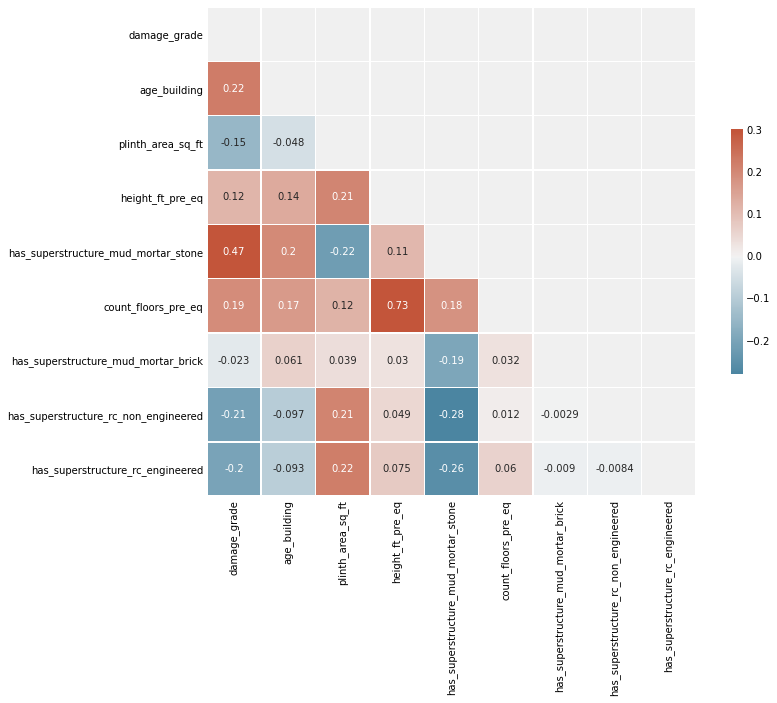

In [17]:
# Compute the correlation matrix of the target variable and most correlated features

corr = df_damage_grade3[df_damage_grade_selct].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot = True);

#### Conclusion
Although the third verion is quite unbalanced it correlates best with the features. Thus, based on our exploration we decide to keep the third version of "damage_grade" as target variable. Later on, we will have to use some over- and undersampling strategies later on to take care of the imbalanced classes.

In [18]:
# Integration of the final target in the df
df = df.replace(damage_grade_version3)
df.damage_grade.value_counts()

3    453211
1    163697
2    134448
Name: damage_grade, dtype: int64

### Feature Engineering Superstructures

Now, we will have a closer look at the superstructure variables and engineer a variable that only holds the "weakest" used material used to build the building and sort the values by empirical mean damage grade in order to create an ordinal variable.

In [19]:
# Select columns that contain "has_superstructure_" in name
lst_columns = list(df.filter(regex='has_superstructure_').columns)

def structure_cat_weak(row, lst_columns):
    for col in lst_columns:
        if row[col] == 1:
            result = col.replace("has_superstructure_", "")
            break
    return result

df['structure_cat_weak'] = df.apply(lambda row: structure_cat_weak(row, lst_columns), axis=1)

lst_value_code_weak = []
for i, col in enumerate(lst_columns):
    lst_value_code_weak.append((col.replace("has_superstructure_", ""),
                           i+1))  
        
repl_structure_weakest = dict(lst_value_code_weak)

df = df.replace({
    'structure_cat_weak': repl_structure_weakest,
                })

#df['structure_cat_weak_emp']
repl_structure_cat_emp = {3: 1, 2: 2, 1: 3, 5: 4, 4: 5, 8: 6, 7: 7, 0: 8, 6: 9, 9: 10, 10: 11}

df['structure_cat_weak_emp'] = df['structure_cat_weak'] 

df = df.replace({
    'structure_cat_weak_emp': repl_structure_cat_emp,
                })

### Feature Engineering Age

Now, we will engineer the age of the buildings. Since the age is right skewed, we will perform a logarithmic transformation of the age to distribute it more normally.

In [20]:
# Log transformation of age_building
df['age_log'] = df['age_building'].apply (lambda row: np.log(int(row)+1))

### Feature Engineering Area & Height

Similar to the age variable we will perform a logarithmic transformation of the area and height variables to achive a more normal distribution. Also, we multiply area and height to build the interaction of both variables. Finally, we log transform the interaction (multiplicative term).

In [21]:
#df['height_log']
df['height_log'] = df['height_ft_pre_eq'].apply (lambda row: np.log(int(row)))

#df['height_log']
df['area_log'] = df['plinth_area_sq_ft'].apply (lambda row: np.log(int(row)))

#df['ia_area_height']
pd.eval("ia_area_height = df.plinth_area_sq_ft * df.height_ft_pre_eq", 
        target=df, inplace=True)

#df['ia_area_height_log']
df['ia_area_height_log'] = df['ia_area_height'].apply (lambda row: np.log(row))

## Final Preparation of the Data and Overview

Finally, we continue with the final preparation of the data for modeling. In this process, we will delete variables from the dataset that are no longer needed and convert object variables into categories. We will also recode our target from 1-3 to 0-2, as this will simplify the modeling of earthquake damage. 

In [22]:
# Var of type object into category
drp_cols = ['building_id', 'technical_solution_proposed', 'age_building', 'plinth_area_sq_ft', 'height_ft_pre_eq', 'structure_cat_weak', 'ia_area_height']
geo_cols = ['district_id', 'vdcmun_id', 'ward_id']
flag_cols = list(df.filter(regex='has_').columns)
obj_cols = list(df.columns[df.dtypes==object])
obj_cols += geo_cols 
obj_cols += flag_cols
df[obj_cols] = df[obj_cols].astype('category')
df = df.dropna(axis=1)
df = df.drop(drp_cols, axis = 1)
repl_target = {1: 0, 2: 1, 3: 2}
df = df.replace({
    'damage_grade': repl_target,
                })
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 751356 entries, 632841 to 607602
Data columns (total 41 columns):
 #   Column                                  Non-Null Count   Dtype   
---  ------                                  --------------   -----   
 0   district_id                             751356 non-null  category
 1   vdcmun_id                               751356 non-null  category
 2   ward_id                                 751356 non-null  category
 3   legal_ownership_status                  751356 non-null  category
 4   count_families                          751356 non-null  float64 
 5   has_secondary_use                       751356 non-null  category
 6   has_secondary_use_agriculture           751356 non-null  category
 7   has_secondary_use_hotel                 751356 non-null  category
 8   has_secondary_use_rental                751356 non-null  category
 9   has_secondary_use_institution           751356 non-null  category
 10  has_secondary_use_school   

### Save Data after Feature Engineering

In [23]:
df.to_pickle('data/model/data_model.pkl', protocol=4)

### EDA with Engineered Features

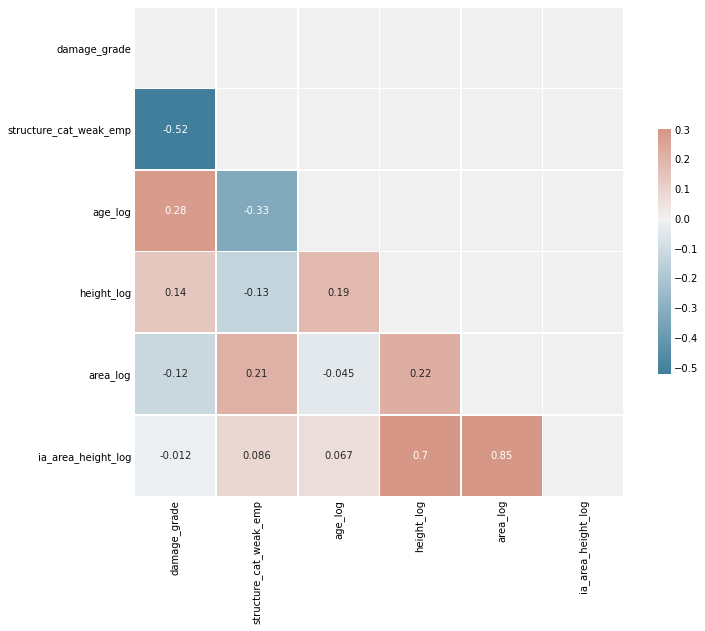

In [24]:
# Compute the correlation matrix of the target variable and most correlated features

lst_engineered_features = df.iloc[:,35:41].columns 

corr = df[lst_engineered_features].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot = True);

### Summary
- From this, we can see that especially the features "structure_cat_weak_emp" and "age_log" are highly correlated with our target.